In [48]:
import math
import operator
from pathlib import Path
from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

from DET import DET

mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

# Biometric performance evaluation
In a biometric system performance evaluation, we distinguish between two types of scores:

* Mated (also called genuine) - i.e. comparisons between different samples (images) from the same data subject (person)
* Non-mated (also called impostor) - i.e. comparisons between samples (images) from different data subjects (persons)

Subsequently, it is evaluated whether correct decisions (accepting mated attempts and rejecting non-mated attempts) can be made based on the scores and a static decision threshold. Let's consider an example.

## Load scores
In this example, scores are conveniently stored in text files and divided into mated and non-mated ones. You may have to do some pre-processing of your own data in order to have the scores neatly stored.

In [99]:
system_name1 = "dlib"
mated_score_file1 = f"{system_name1}_mated.txt.gz"
nonmated_score_file1 = f"{system_name1}_nonmated.txt.gz"
mated_scores1 = np.loadtxt(mated_score_file1)
nonmated_scores1 = np.loadtxt(nonmated_score_file1)
scores_type1 = "similarity"

## Explore scores
Let's explore the scores with some basic descriptive statistical methods.

In [100]:
def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()

/var/folders/_h/ggw2rc692z308bcs84s8cc2h0000gn/T/ipykernel_70171/1317522594.py:13: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  stats_system1_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,4884.000000,2479400.000000
Minimum,0.865130,0.660310
Maximum,0.997830,0.976670
Mean,0.959950,0.847440
St. Dev.,0.012090,0.036220
Skewness,-0.753880,0.081260
Ex. Kurtosis,2.424580,0.016490


We can observe several things. There are many more non-mated scores than mated scores -- this is typical, since there simply are many more possibilities of comparing samples from two different subjects than from the same subjects. Also, the mated scores tend to be closer to 1 (perfect similarity) than the non-mated scores. That is good -- perhaps there is a clear separation between the two? Fortunately, we can investigate that as well.

## Plot histograms
Using histograms, the distributions of the two score types can be visualised.

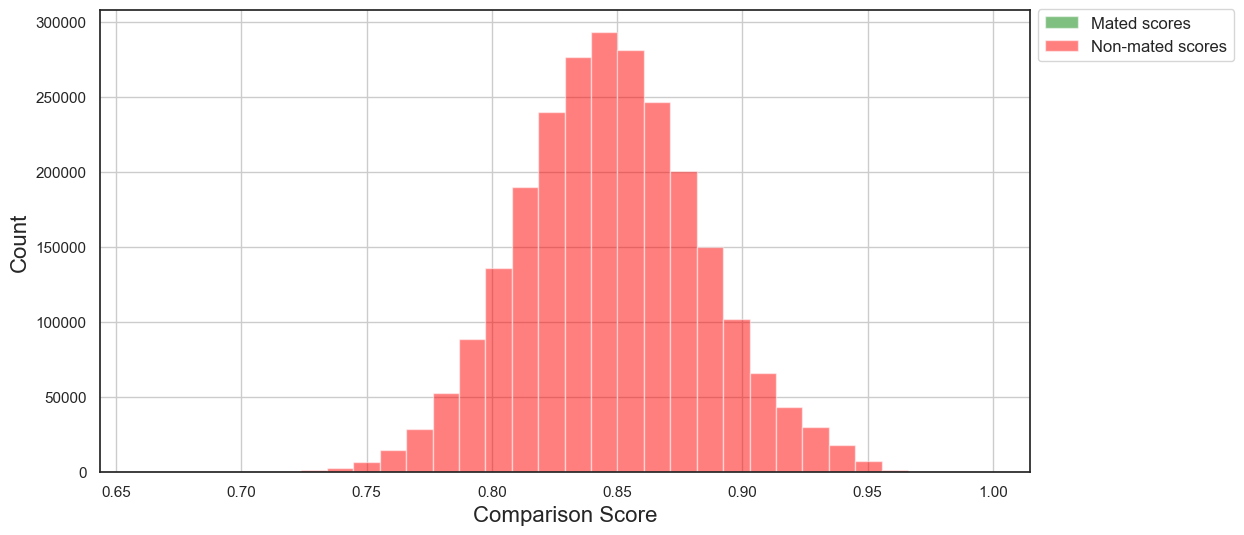

In [101]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()
    
plot_histogram(mated_scores1, nonmated_scores1, normalise=False)

Typically, we have more (sometimes orders of magnitude) non-mated comparison scores available -- we need to normalise!

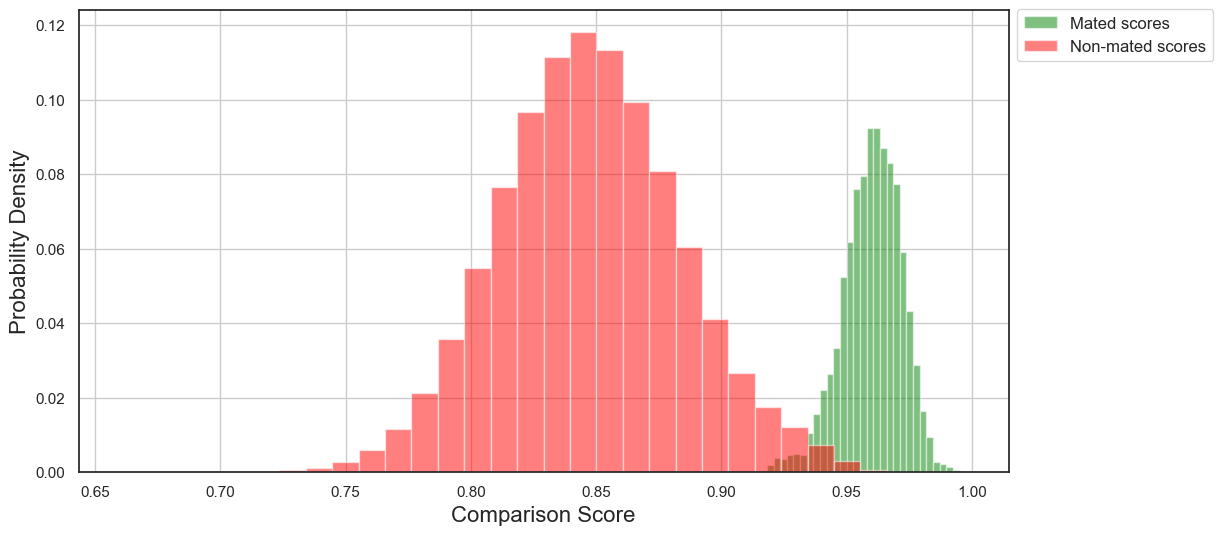

In [102]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

This now looks much better. We can also use a built-in KDE function.

In [103]:
def get_kde(distribution, linspace_items=101):
    dist_min, dist_max = distribution.min(), distribution.max()
    dist_kde = gaussian_kde(distribution)
    dist_pos = np.linspace(dist_min, dist_max, linspace_items)
    return dist_kde, dist_pos, dist_min, dist_max

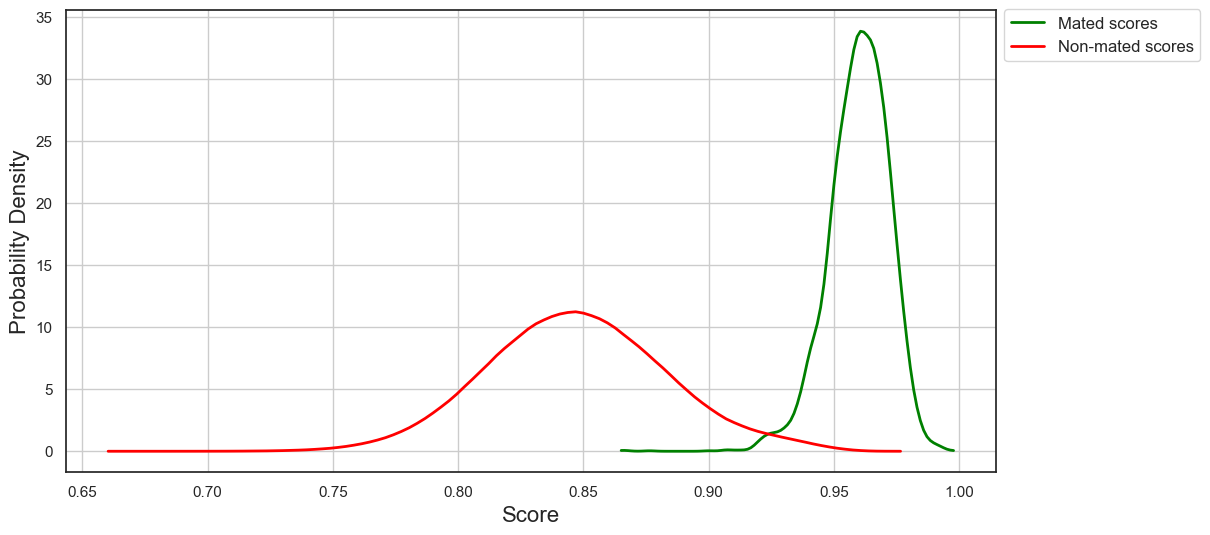

In [104]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

## Separability and Thresholding
There seems to be a decent separation (i.e. not much overlap) between the two score distributions above. We can quantify this using the so-called [sensitivity index](https://en.wikipedia.org/wiki/Sensitivity_index), which is a dimensionless metric which measures the separation between two distributions. Although it assumes the data is normally distributed (which is not always the case with biometric data) and does not take into account higher order moments (e.g. skewness and kurtosis), it can still give a reasonable approximate of how well the mated and non-mated scores are separated (larger value means better separation). It is computed as follows: $$d' = \frac{\|\mu_{mated} - \mu_{non-mated}\|}{\sqrt{\frac{1}{2}\left(\sigma_{mated}^2 + \sigma_{non-mated}^2\right)}}$$

In [106]:
def d_prime(distribution1, distribution2):
    mean1, mean2 = np.mean(distribution1), np.mean(distribution2)
    std1, std2 = np.std(distribution1), np.std(distribution2)
    return abs(mean1 - mean2) / math.sqrt(0.5 * (std1 ** 2 + std2 ** 2))

In [107]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' =", round(d_prime_system1, round_digits))

d' = 4.16704


Since the distributions are quite well separated, it means, that if we were to set a static score threshold, it would be possible to classify a (new) score as either "mated" if it is above the threshold, or "non-mated" if it is below. Let's visualise this.

In [130]:
def kde_with_threshold(mated_scores, nonmated_scores, scores_type, threshold, savename=None): 
    linspace_items = 101
    mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores, linspace_items)
    nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores, linspace_items)
    
    plt.figure(figsize=figure_size)
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel("Probability Density", size=label_fontsize)
    
    def compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items):
        if scores_type == "similarity":
            if mated_min < threshold:
                mated_shade = np.linspace(threshold, mated_max, linspace_items)
                mated_fill = np.linspace(mated_min, threshold, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_max > threshold:
                nonmated_shade = np.linspace(nonmated_min, threshold, linspace_items)
                nonmated_fill = np.linspace(threshold, nonmated_max, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        elif scores_type == "dissimilarity":
            if mated_max > threshold:
                mated_shade = np.linspace(mated_min, threshold, linspace_items)
                mated_fill = np.linspace(threshold, mated_max, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_min < threshold:
                nonmated_shade = np.linspace(threshold, nonmated_max, linspace_items)
                nonmated_fill = np.linspace(nonmated_min, threshold, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        else:
            raise ValueError(f"Unknown type of comparison scores: {scores_type}")
        return mated_shade, mated_fill, nonmated_shade, nonmated_fill
    
    plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
    plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
     
    mated_shade, mated_fill, nonmated_shade, nonmated_fill = compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items)
    
    plt.fill_between(mated_shade, mated_kde(mated_shade), alpha=alpha_shade, color=mated_colour) 
    plt.fill_between(nonmated_shade, nonmated_kde(nonmated_shade), alpha=alpha_shade, color=nonmated_colour) 
    
    if mated_fill is not None:
        plt.fill_between(mated_fill, mated_kde(mated_fill), alpha=alpha_fill, color=mated_colour)
    if nonmated_fill is not None:
        plt.fill_between(nonmated_fill, nonmated_kde(nonmated_fill), alpha=alpha_fill, color=nonmated_colour)

    plt.axvline(threshold, linewidth=linewidth, linestyle=threshold_style, color=threshold_colour, label="Decision threshold")
    
    plt.legend(loc=0)
    red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_fill, label='False positives')
    green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_fill, label='False negatives')
    shaded_red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_shade, label='True negatives')
    shaded_green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_shade, label='True positives')
    current_handles, _ = plt.gca().get_legend_handles_labels()
    
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize, handles=[green_patch, red_patch, shaded_green_patch, shaded_red_patch]+current_handles)
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

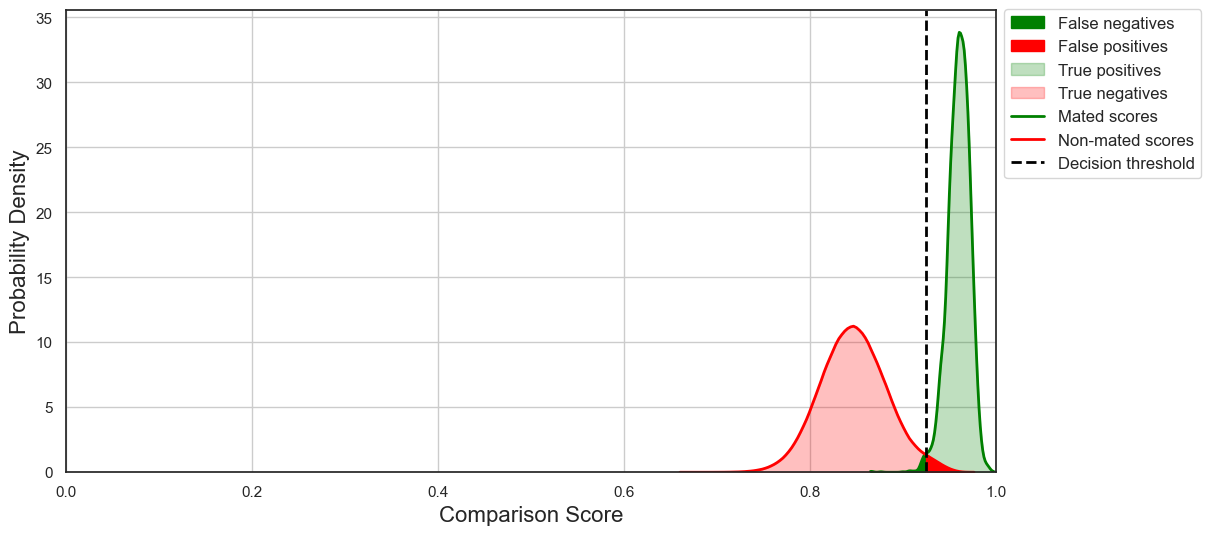

In [131]:
threshold1 = 0.925
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

What happened? We set the decision threshold to 0.5. Every score above this threshold is classified as "mated", whereas every score below that threshold is classified as "non-mated". In the plot, we can see that most items would have been classified correctly (mated as mated, i.e. accepted, and non-mated as non-mated, i.e. rejected) -- those are the parts of distribution with bleak colour (low alpha value). However, some classification errors (mated as non-mated, i.e. rejected, and non-mated as mated, i.e. accepted) would have occurred -- those are the highlighted parts of the distributions (high alpha value). Let's quantify those errors in a confusion matrix.

## Confusion matrix
[This commonly used method](https://en.wikipedia.org/wiki/Confusion_matrix) allows us to concisely visualise the performance (accuracy) of our decision making algorithm at a given threshold.

In [132]:
def get_confusion_matrix(mated_scores, nonmated_scores, scores_type, threshold, mode="percent"):
    if scores_type == "similarity":
        true_accepts_count = [score >= threshold for score in mated_scores].count(True)
        true_rejects_count = [score < threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score >= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score < threshold for score in mated_scores].count(True)
    elif scores_type == "dissimilarity":
        true_accepts_count = [score <= threshold for score in mated_scores].count(True)
        true_rejects_count = [score > threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score <= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score > threshold for score in mated_scores].count(True)
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")
    if mode == "count":
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_count, false_rejects_count], [false_accepts_count, true_rejects_count]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    elif mode == "percent":
        mated_count = len(mated_scores)
        nonmated_count = len(nonmated_scores)
        true_accepts_percent = true_accepts_count / mated_count * 100
        true_rejects_percent = true_rejects_count / nonmated_count * 100
        false_accepts_percent = false_accepts_count / nonmated_count * 100
        false_rejects_percent = false_rejects_count / mated_count * 100
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_percent, false_rejects_percent], [false_accepts_percent, true_rejects_percent]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    else:
        raise ValueError("Wrong mode: {}".format(mode))
    return confusion_matrix_system_df.astype({"Predicted/Actual": str, "Mated": float if mode == "percent" else int, "Non-mated": float if mode == "percent" else int})

def style_confusion_matrix(confusion_matrix):
    hex_color_green_fill = "#008000"
    hex_color_red_shade = "#ffbfbf"
    hex_color_green_shade = "#bfdfbf"
    hex_color_red_fill = "#ff0000"
    return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()

style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count"))

/var/folders/_h/ggw2rc692z308bcs84s8cc2h0000gn/T/ipykernel_70171/3192259722.py:33: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,4836,53313
Non-mated,48,2426087


We can also compute the matrix as percentages:

In [133]:
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="percent").round(round_digits))

/var/folders/_h/ggw2rc692z308bcs84s8cc2h0000gn/T/ipykernel_70171/3192259722.py:33: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,99.017200,2.150240
Non-mated,0.982800,97.849760


In other words, we correctly classify approximately 95% of mated attempts as mated (true accept), and approximately 95% of non-mated attempts as non-mateds (true rejects). However, some errors are present -- approximately 5% non-mated attempts are incorrectly classified as mated (false accepts, type I error), and approximately 5% of mated attempts as non-mateds (false rejects, type II error). **By computing the accuracy at the given threshold, we found one operating point of the algorithm we are evaluating. But, what about other thresholds?** We could have tested arbitrarily many thresholds in the range of the score distributions to visualise the entire spectrum of possible operating points. Let's try this.

## DET curves
A detection error tradeoff curve allows to plot the entire spectrum of operating points (error rates), i.e. the false non-match rate vs. false match rate. It is used in standardised evaluation of biometric systems (as mandated by the international standard [ISO/IEC 19795-1](https://www.iso.org/standard/73515.html)).

In [134]:
def adjust_scores_for_DET(scores_array, scores_type):
    scores_array = np.asarray(scores_array)
    if scores_type == "similarity":
        return scores_array
    elif scores_type == "dissimilarity":
        return -scores_array
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")

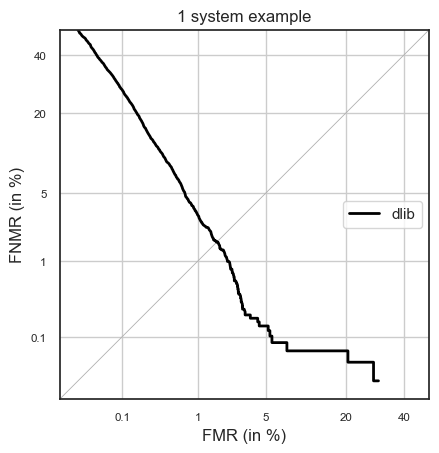

In [135]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="1 system example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.legend_on()
det.show()

Now we are able to see the whole spectrum of the trade-off between false positive occurrences (false match rate - FMR) and false negative occurrences (false non-match rate - FNMR). Also drawn (faint grey) is the so-called equal-error-rate (EER) line -- which merely goes through points where the FMR and FNMR are equal. It is sometimes used to summarise the biometric performance of a system in a single number, but it may be misleading (not showing the whole picture) in some cases. We can see the EER is where the grey and black lines intersect -- around 5%. Last, but not least, how do we benchmark (compare) the biometric performance of two or more systems? It is simple -- we plot their respective DET curves in one figure.

In [136]:
system_name2 = "insightface"
mated_score_file2 = f"{system_name2}_mated.txt.gz"
nonmated_score_file2 = f"{system_name2}_nonmated.txt.gz"
mated_scores2 = np.loadtxt(mated_score_file2)
nonmated_scores2 = np.loadtxt(nonmated_score_file2)
scores_type2 = "similarity"

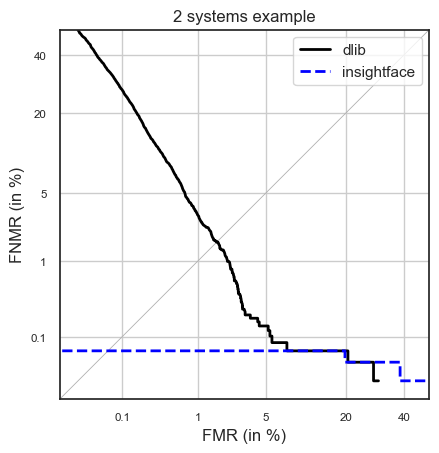

In [137]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="2 systems example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()

We can thus conclude that across the whole spectrum, system 2 performs significantly better (has lower error rates) than system 1. Another metric commonly used to describe a system's biometric performance (accuracy) is equal-error-rate (EER). It can be computed by interpolating on FMR and FNMR values or read from the figure directly. It simply denotes the point at which the two error rates are equal, i.e. FMR == FNMR. That is the point, where the grey diagonal line starting at origin intersects with the DET curves for the respective systems. For example, the EER for system 1 would be around 5%, whereas for system 2 it would be below 1%.

## Similarity vs dissimilarity scores

Biometric samples can be compared in two distinct (but essentially/effectively the same) ways, by computing:

* Similarity scores. Systems 1 and 2 utilised those. Here, the biometric comparator establishes the degree of similarity between two biometric samples and outputs that as a score. Consequently, the scores for mated comparisons are expected to be high, whereas the scores for the non-mated comparisons are expected to be low. 
* Dissimilarity scores. Let's introduce system 3, which utilises those. Here, the biometric comparator establishes the degree of dissimilarity (distance) between two biometric samples and outputs that as a score. Consequently, the scores for mated comparisons are expected to be low, whereas the scores for the non-mated comparisons are expected to be high.

We can effortlessly convert between those types of scores, but it is important to know which are used in order to avoid wrong behaviours of software or strange results. Let's try to do some evaluations on system 3 and its dissimilarity scores.

In [181]:
system_name3 = "deepface"
mated_score_file3 = f"{system_name3}_mated.txt.gz"
nonmated_score_file3 = f"{system_name3}_nonmated.txt.gz"
mated_scores3 = np.loadtxt(mated_score_file3)
nonmated_scores3 = np.loadtxt(nonmated_score_file3)
scores_type3 = "similarity"

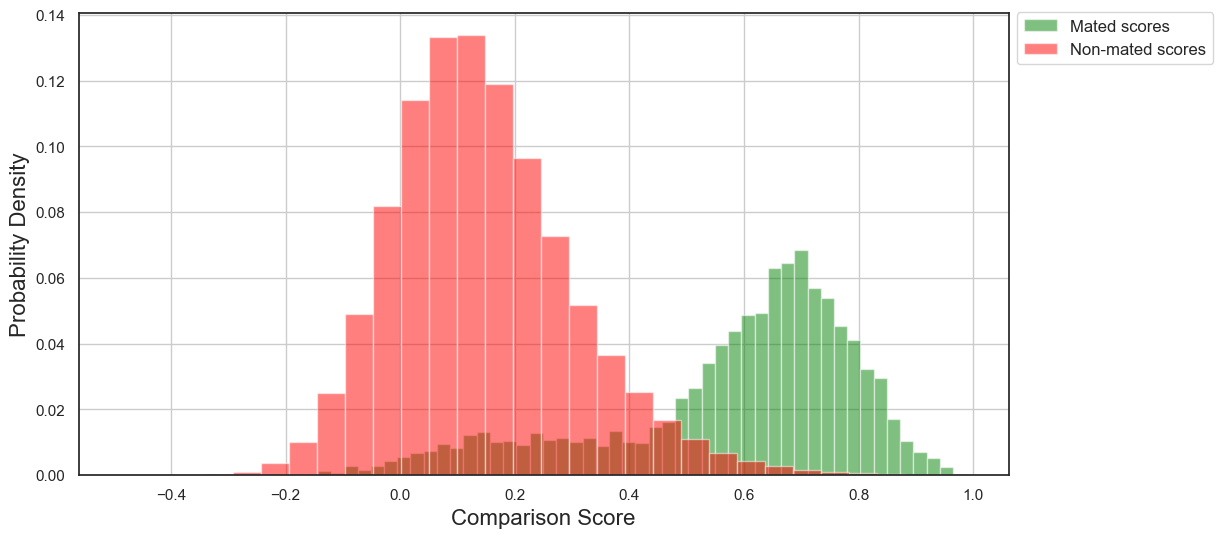

In [182]:
plot_histogram(mated_scores3, nonmated_scores3, normalise=True)

As expected, the distributions have exchanged their positions -- now the non-mated scores are high and mated scores are low. 

For the example with histogram and thresholds, as well as the calculation of errors, we need to be careful which way the comparison symbols (>,<,>=,<=) are pointing -- see the handling of this in *histogram_with_threshold* and *get_confusion_matrix* functions. Let's try to plug in the system 3 scores to those.

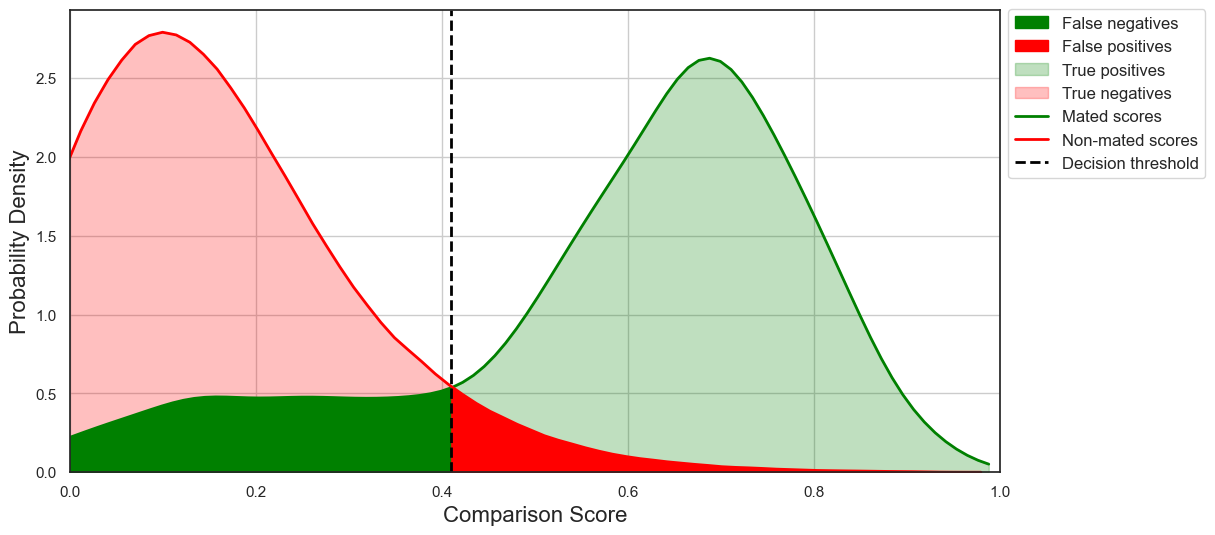

/var/folders/_h/ggw2rc692z308bcs84s8cc2h0000gn/T/ipykernel_70171/3192259722.py:33: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,80.467310,6.056070
Non-mated,19.532690,93.943930


In [183]:
threshold3 = 0.41
kde_with_threshold(mated_scores3, nonmated_scores3, scores_type3, threshold3)
style_confusion_matrix(get_confusion_matrix(mated_scores3, nonmated_scores3, scores_type3, threshold3, mode="percent").round(round_digits))

The d' calculation, on the other hand is not affected, as we are taking the *absolute* difference of $\mu$'s in the numerator.

In [184]:
d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
print("d' =", round(d_prime_system3, round_digits))

d' = 2.25887


Finally, we plot the DET curves for system 1 (similarity scores) and system 3 (dissimilarity scores), remembering to adjust the input according to the type of the comparison scores using the *adjust_scores_for_DET* function. The *det.plot* function expects similarity scores as input, so we actually only need to flip the sign of the dissimilarity scores.

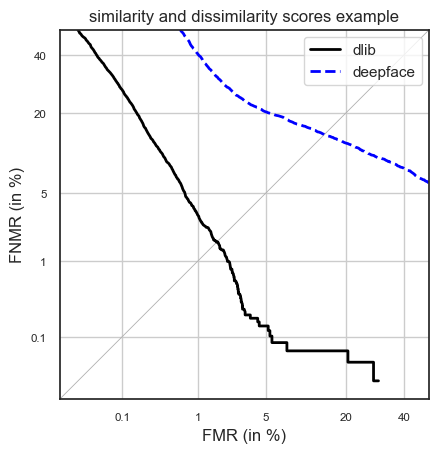

In [185]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="similarity and dissimilarity scores example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores3, scores_type3), non=adjust_scores_for_DET(nonmated_scores3, scores_type3), label=system_name3)
det.legend_on(loc="upper right")
det.show()

## Interactive threshold

In the visualisation below, the decision threshold can be set interactively. Try a few different settings and check your intuition regarding the resulting system errors!

Note, that this section is experimental and may not work on all platforms/browsers. If it fails, just use the code from before and manually change the variables for the scores and threshold.

```python
threshold_new = 0.55
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold_new)
```

In [174]:
def kde_with_threshold_interactive(system_number, threshold):
    alpha_shade = 0.25
    alpha_fill = 1.0
    linewidth = 2
    legend_loc = "upper left"
    legend_anchor = (1.0, 1.02)
    legend_cols = 1
    legend_fontsize = 12
    label_fontsize = 16
    mated_colour = "green"
    nonmated_colour = "red"
    threshold_colour = "black"
    threshold_style = "--"
    hex_color_green_fill = "#008000"
    hex_color_red_shade = "#ffbfbf"
    hex_color_green_shade = "#bfdfbf"
    hex_color_red_fill = "#ff0000"
    linspace_items = 101
    mated_scores, nonmated_scores, scores_type = systems[int(system_number)-1]
    mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores, linspace_items)
    nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores, linspace_items)
    
    plt.figure(figsize=(12,6))
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel("Probability Density", size=label_fontsize)
    
    def compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items):
        if scores_type == "similarity":
            if mated_min < threshold:
                mated_shade = np.linspace(threshold, mated_max, linspace_items)
                mated_fill = np.linspace(mated_min, threshold, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_max > threshold:
                nonmated_shade = np.linspace(nonmated_min, threshold, linspace_items)
                nonmated_fill = np.linspace(threshold, nonmated_max, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        elif scores_type == "dissimilarity":
            if mated_max > threshold:
                mated_shade = np.linspace(mated_min, threshold, linspace_items)
                mated_fill = np.linspace(threshold, mated_max, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_min < threshold:
                nonmated_shade = np.linspace(threshold, nonmated_max, linspace_items)
                nonmated_fill = np.linspace(nonmated_min, threshold, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        else:
            raise ValueError(f"Unknown type of comparison scores: {scores_type}")
        return mated_shade, mated_fill, nonmated_shade, nonmated_fill
    
    plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
    plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
     
    mated_shade, mated_fill, nonmated_shade, nonmated_fill = compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items)
    
    plt.fill_between(mated_shade, mated_kde(mated_shade), alpha=alpha_shade, color=mated_colour) 
    plt.fill_between(nonmated_shade, nonmated_kde(nonmated_shade), alpha=alpha_shade, color=nonmated_colour) 
    
    if mated_fill is not None:
        plt.fill_between(mated_fill, mated_kde(mated_fill), alpha=alpha_fill, color=mated_colour)
    if nonmated_fill is not None:
        plt.fill_between(nonmated_fill, nonmated_kde(nonmated_fill), alpha=alpha_fill, color=nonmated_colour)

    plt.axvline(threshold, linewidth=linewidth, linestyle=threshold_style, color=threshold_colour, label="Decision threshold")
    
    plt.legend(loc=0, ncol=2)
    red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_fill, label='False positives')
    green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_fill, label='False negatives')
    shaded_red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_shade, label='True negatives')
    shaded_green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_shade, label='True positives')
    current_handles, _ = plt.gca().get_legend_handles_labels()
    
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize, handles=[green_patch, red_patch, shaded_green_patch, shaded_red_patch]+current_handles)
    plt.xlim(0, 1)
    plt.ylim(0, None)
    confusion_matrix = get_confusion_matrix(mated_scores, nonmated_scores, scores_type, threshold, mode="percent").round(round_digits)
    return style_confusion_matrix(confusion_matrix)

In [176]:
systems = [(mated_scores1, nonmated_scores1, "similarity"),
          (mated_scores2, nonmated_scores2, "similarity"),
          (mated_scores3, nonmated_scores3, "similarity"),
          ]

interactive_plot_caption = widgets.HTML(value=r'Investigate how changes in <b>threshold</b> affect the plots and error rates! Use the box buttons or type a number and press the "Enter" key.')
system_number_selector = widgets.Dropdown(options=[str(el) for el in range(1, len(systems)+1)], value='1', description="System")
threshold_value_selector = widgets.FloatText(min=0.0, max=1.0, step=0.01, value=0.5, description="Threshold")
display(interactive_plot_caption)

interact(kde_with_threshold_interactive, system_number=system_number_selector, threshold=threshold_value_selector);

HTML(value='Investigate how changes in <b>threshold</b> affect the plots and error rates! Use the box buttons …

interactive(children=(Dropdown(description='System', options=('1', '2', '3'), value='1'), FloatText(value=0.5,…

# Exercises

1. Load the comparison score files for system 4. 
 1. Does the system work with similarity or dissimilarity scores?
 2. What is the worst mated score? What is the best non-mated score?
 3. Compute d' for this system. Is it better or worse than those of systems 1-3?
 4. How many false negative and false positive errors are there at threshold 0.35?
 5. Compute the false negative and false positive errors at threshold 0.40 relative to the overall number of attempts.
 6. Plot KDEs with thresholds visualising the results of points D and E.
2. Load the comparison score files for system 5.
 1. Plot DET curves for systems 4 and 5 in the same figure.
 2. Repeat point A, but this time narrow down the displayed axes range to [0.01%, 1%] and adjust the axis ticks increments accordingly.
 2. Which of the two systems performs better? Explain.
3. Compute descriptive statistics for systems 4 and 5.
 1. Describe the respective differences and similarities across the two systems.
4. What do the outliers in the score distributions signify? (in real world terms)
 1. Give (in real world terms) 3 reasons for why a mated attempt may result in an unusually poor comparison score.
 2. Give (in real world terms) 3 reasons for why a non-mated attempt may result in an unusually good comparison score.
5. What are the coordinates (x,y) of the theoretical optimal biometric performance in a DET plot?
6. What is the equal-error-rate for system 5? Approximate it visually on the DET curve.
7. What is the false non-match rate at the false match rate of 0.1% (i.e. the point FNMR(FMR=0.1%)) for system 5? Approximate it visually on the DET curve.
8. Explain (in your own words) what the false match rate (FMR) and false non-match rate (FNMR) express.
 1. Which of the above two error rates relates to the security of a biometric system?
 2. Which of the above two error rates relates to the convenience of a biometric system?
 3. What do you think would be a reasonable level of FMR in an actual deployment of a biometric system? Would it be the same or different as that for FNMR? Would those differ by the real-world application scenario? Why or why not? Explain and argument for your opinions.
9. Plot DET curves for all 5 systems in one figure.
10. (challenge) Write code to compute EER, as well as FNMR(FMR=X) from the lists of mated and non-mated scores.
 1. Use the code to compute the error rates from exercises 6 and 7.

# Solutions

## 1

In [ ]:
system_name4 = "system4"
mated_score_file4 = f"{system_name4}_mated.txt.gz"
nonmated_score_file4 = f"{system_name4}_nonmated.txt.gz"
mated_scores4 = np.loadtxt(mated_score_file4)
nonmated_scores4 = np.loadtxt(nonmated_score_file4)

## 1.A

In [ ]:
plot_histogram(mated_scores4, nonmated_scores4, normalise=True)

Dissimilarity scores -- mated scores are lower than non-mated scores.

In [ ]:
scores_type4 = "dissimilarity"

## 1.B

In [ ]:
worst_mated4 = max(mated_scores4)
best_nonmated4 = min(nonmated_scores4)
print("System 4")
print(f"Worst mated score: {worst_mated4}")
print(f"Best non-mated score: {best_nonmated4}")

## 1.C

In [ ]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
d_prime_system4 = d_prime(mated_scores4, nonmated_scores4)
for system_number, d_prime_value in enumerate([d_prime_system1, d_prime_system2, d_prime_system3, d_prime_system4], start=1):
    print(f"System {system_number} d' = {round(d_prime_value, round_digits)}")

d' for system 4 is better (higher) than those of systems 1-3. d' of system 3, however, is only minimally smaller than that of system 4.

## 1.D

In [ ]:
threshold4_1 = 0.35
style_confusion_matrix(get_confusion_matrix(mated_scores4, nonmated_scores4, scores_type4, threshold4_1, mode="count"))

## 1.E

In [ ]:
threshold4_2 = 0.40
style_confusion_matrix(get_confusion_matrix(mated_scores4, nonmated_scores4, scores_type4, threshold4_2, mode="percent").round(round_digits))

## 1.F

In [ ]:
kde_with_threshold(mated_scores4, nonmated_scores4, scores_type4, threshold4_1)
kde_with_threshold(mated_scores4, nonmated_scores4, scores_type4, threshold4_2)

## 2

In [ ]:
system_name5 = "system5"
mated_score_file5 = f"{system_name5}_mated.txt.gz"
nonmated_score_file5 = f"{system_name5}_nonmated.txt.gz"
mated_scores5 = np.loadtxt(mated_score_file5)
nonmated_scores5 = np.loadtxt(nonmated_score_file5)
scores_type5 = "dissimilarity"

## 2.A

In [ ]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="2 systems example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores4, scores_type4), non=adjust_scores_for_DET(nonmated_scores4, scores_type4), label=system_name4)
det.plot(tar=adjust_scores_for_DET(mated_scores5, scores_type5), non=adjust_scores_for_DET(nonmated_scores5, scores_type5), label=system_name5)
det.legend_on(loc="upper right")
det.show()

## 2.B

In [ ]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="2 systems example")
det.x_limits = np.array([1e-4, 1e-2])
det.y_limits = np.array([1e-4, 1e-2])
det.x_ticks = np.array([1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2])
det.x_ticklabels = np.array(['0.01', '0.02', '0.05', '0.1', '0.2', '0.5', '1'])
det.y_ticks = np.array([1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2])
det.y_ticklabels = np.array(['0.01', '0.02', '0.05', '0.1', '0.2', '0.5', '1'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores4, scores_type4), non=adjust_scores_for_DET(nonmated_scores4, scores_type4), label=system_name4)
det.plot(tar=adjust_scores_for_DET(mated_scores5, scores_type5), non=adjust_scores_for_DET(nonmated_scores5, scores_type5), label=system_name5)
det.legend_on(loc="lower right")
det.show()

## 2.C

System 5 performs much better than system 4.

## 3

In [ ]:
stats_system4_df = descriptive_statistics(mated_scores4, nonmated_scores4)
stats_system5_df = descriptive_statistics(mated_scores5, nonmated_scores5)

## 3.A

In [ ]:
stats_system4_df.style.hide_index()

In [ ]:
stats_system5_df.style.hide_index()

In [ ]:
kde_with_threshold(mated_scores4, nonmated_scores4, scores_type4, 0.4)
kde_with_threshold(mated_scores5, nonmated_scores5, scores_type5, 0.4)

The non-mated distribution exhibit similar shapes (nearly identical higher statistical moments), except that that for system 5 is shifted more towards the right (higher mean, minimum, and maximum). The mean of the mated distribution of system 5 is worse than that of system 4, however, the mated distribution for system 4 is much more spread out than that of system 5.

## 4

Outliers correspond to unusally poor or good (w.r.t. average) comparison scores.

## 4.A

For example:
1. Poor image quality.
2. Subject ageing.
3. Pure chance.

## 4.B

For example:

1. Siblings.
2. Lookalikes.
3. Pure chance.

## 5

(x, y) = (0, 0), i.e. no false positive and no false negative errors.

## 6

Equal-error-rate is the point on the DET curve at which FMR and FNMR are equal.

In [ ]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="system 4")
det.x_limits = np.array([5e-3, 8e-3])
det.y_limits = np.array([5e-3, 8e-3])
det.x_ticks = np.array([5e-3, 6e-3, 7e-3, 8e-3])
det.x_ticklabels = np.array(['0.5', '0.6', '0.7', '0.8'])
det.y_ticks = np.array([5e-3, 6e-3, 7e-3, 8e-3])
det.y_ticklabels = np.array(['0.5', '0.6', '0.7', '0.8'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores4, scores_type4), non=adjust_scores_for_DET(nonmated_scores4, scores_type4), label=system_name4)
det.legend_on(loc="upper right")
det.show()

The EER is slightly above 0.6%.

## 7

In [ ]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="system 5")
det.x_limits = np.array([1e-4, 2e-3])
det.y_limits = np.array([1e-4, 1e-3])
det.x_ticks = np.array([1e-4, 5e-4, 1e-3])
det.x_ticklabels = np.array(['0.01','0.05', '0.1'])
det.y_ticks = np.array([1e-4, 5e-4, 1e-3])
det.y_ticklabels = np.array(['0.01', '0.05', '0.1'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores5, scores_type5), non=adjust_scores_for_DET(nonmated_scores5, scores_type5), label=system_name5)
det.legend_on(loc="upper right")
det.show()

FNMR(FMR=0.1%) is around 0.05%.

## 8

FMR: "proportion of the completed biometric non-mated comparison trials that result in a false match"
    
FNMR: "proportion of the completed biometric mated comparison trials that result in a false non-match"

## 8.A

FMR.

## 8.B

FNMR.

## 8.C

Depends on the application scenario -- discuss in class.

## 9

In [ ]:
systems = [(mated_scores1, nonmated_scores1, "similarity"),
          (mated_scores2, nonmated_scores2, "similarity"),
          (mated_scores3, nonmated_scores3, "dissimilarity"),
          (mated_scores4, nonmated_scores4, "dissimilarity"),
          (mated_scores5, nonmated_scores5, "dissimilarity")
          ]

det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="All systems example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
for i, (mated_scores, nonmated_scores, scores_type) in enumerate(systems, start=1):
    det.plot(tar=adjust_scores_for_DET(mated_scores, scores_type), non=adjust_scores_for_DET(nonmated_scores, scores_type), label=f"System {i}")
det.legend_on(loc="upper right")
det.show()

## 10

code from pyeer package: https://github.com/manuelaguadomtz/pyeer/blob/master/pyeer/eer_stats.py

In [ ]:
def calculate_roc(gscores, iscores, ds_scores=False, rates=True):
    if isinstance(gscores, list):
        gscores = np.array(gscores, dtype=np.float64)

    if isinstance(iscores, list):
        iscores = np.array(iscores, dtype=np.float64)

    if gscores.dtype == np.int:
        gscores = np.float64(gscores)

    if iscores.dtype == np.int:
        iscores = np.float64(iscores)

    if ds_scores:
        gscores = gscores * -1
        iscores = iscores * -1

    gscores_number = len(gscores)
    iscores_number = len(iscores)

    gscores = zip(gscores, [1] * gscores_number)
    iscores = zip(iscores, [0] * iscores_number)

    gscores = list(gscores)
    iscores = list(iscores)

    scores = np.array(sorted(gscores + iscores, key=operator.itemgetter(0)))
    cumul = np.cumsum(scores[:, 1])

    thresholds, u_indices = np.unique(scores[:, 0], return_index=True)

    fnm = cumul[u_indices] - scores[u_indices][:, 1]
    fm = iscores_number - (u_indices - fnm)

    if rates:
        fnm_rates = fnm / gscores_number
        fm_rates = fm / iscores_number
    else:
        fnm_rates = fnm
        fm_rates = fm

    if ds_scores:
        return thresholds * -1, fm_rates, fnm_rates

    return thresholds, fm_rates, fnm_rates

def get_fmr_op(fmr, fnmr, op):
    index = np.argmin(abs(fmr - op))
    return fnmr[index]

def get_eer(fmr, fnmr):
    diff = fmr - fnmr
    t2 = np.where(diff <= 0)[0]

    if len(t2) > 0:
        t2 = t2[0]
    else:
        return 0, 1, 1, 1

    t1 = t2 - 1 if diff[t2] != 0 and t2 != 0 else t2

    return (fnmr[t2] + fmr[t2]) / 2

## 10.A

In [ ]:
thresholds_system4, fmrs_system4, fnmrs_system4 = calculate_roc(mated_scores4, nonmated_scores4, ds_scores=scores_type4=="dissimilarity")
thresholds_system5, fmrs_system5, fnmrs_system5 = calculate_roc(mated_scores5, nonmated_scores5, ds_scores=scores_type5=="dissimilarity")

In [ ]:
print("System 4 EER:", round(get_eer(fmrs_system4, fnmrs_system4) * 100, round_digits))
print("System 5 FNMR(FMR=0.1%):", round(get_fmr_op(fmrs_system5, fnmrs_system5, 0.001) * 100, round_digits))